In [1]:
from typing_extensions import ParamSpecArgs
from jax._src.api import jit
from sklearn.utils import shuffle
from scipy import signal
from google.colab import files

import jax.numpy as jnp, random
import numpy as np
import os, shutil
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math

In [ ]:
"""Creating the Layers for the CNN"""

class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    pass
  
  def backward(self, o_grad, lr):
    """
      where o_grad = output gradient
            lr = learning rate
    """
    pass

class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))


class Convolutional(Layer):
  def __init__(self, input_shape, kernel_size, depth):
    self.input_depth, self.input_width, self.input_height = input_shape
    self.depth = depth
    self.input_shape = input_shape

    """
      y = x - K + 1
    """
    self.output_shape = (depth, self.input_height - kernel_size + 1, self.input_width - kernel_size + 1)
    self.kernels_shape = (depth, self.input_depth, kernel_size, kernel_size)
    self.kernels = np.random.normal(*self.kernels_shape)
    self.biases = np.random.normal(*self.output_shape)
  
  def forward(self, input):
    self.input = input
    self.output = np.copy(self.biases)
    
    """
      output(y) = Bias(b) + Sum( Input( x ) * Kernel( K ) )
      where: * = Cross Correlation
    
    """
    for i in range(self.depth):
      for j in range(self.input_depth):
        self.output[i] += signal.correlate2d(self.input[j], self.kernels[i,j], "valid")
    
    return self.output
  
  @jit
  def backward(self, o_grad, lr):
    #update params and return input grad

    kernels_gradient = np.zeros(self.kernels_shape)
    input_gradient = np.zeros(self.input_shape)

    for i in range(self.depth):
      for j in range(self.input_depth):
        kernels_gradient[ i , j ] = signal.correlate2d(self.input[j], o_grad[i], "valid")
        input_gradient[ j ] += signal.convolve2d(o_grad[i], self.kernels[ i , j ], "full")

    self.kernels -= lr * kernels_gradient
    self.biases -= lr * o_grad

    return input_gradient


class Convolutional_2(Layer):
  def __init__(self, num_filters, filter_size):
    self.num_filters = num_filters
    self.filter_size = filter_size
    self.conv_filter = np.random.randn(num_filters, filter_size, filter_size) / (filter_size * filter_size)

  def image_region(self, image):
    height, width = image.shape
    self.image = image
    for j in range(height - self.filter_size + 1):
      for k in range(width - self.filter_size + 1):
        image_patch = image [j : (j+self.filter_size), k:( k + self.filter_size)]
        yield image_patch, j, k
  
  def forward(self, images):
    height, width = images.shape
    self.image = images

    conv_out = np.zeros((height - self.filter_size + 1 , width - self.filter_size + 1, self.num_filters))
    for image_patch , i , j in self.image_region(images):
      conv_out[i,j] = np.sum(image_patch * self.conv_filter, axis = (1,2))
    return conv_out

  def backward(self, dL_dout, lr):
    dL_dF_params = np.zeros(self.conv_filter.shape)
    for image_patch, i, j in self.image_region(self.images):
      for k in range(self.num_filters):
        dL_dF_params[k] += image_patch * dL_dout[i,j,k]
    
    #update params
    self.conv_filter -= lr * dL_dF_params
    return dL_dF_params




class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient

"""
  Reshape Layer ==> the output of the Conv Layer is 3d and must be reshaped
"""

class Reshape(Layer):
  def __init__(self, input_shape, output_shape):
    self.input_shape = input_shape
    self.output_shape = output_shape

  def forward(self, input):
    return np.reshape(input, self.output_shape)
  
  def backward(self, o_grad, lr):
    return np.reshape(o_grad, self.input_shape)

"""
  For this task, i believe that RMSE would be the better error to use as opposed to
  BCE (however i did provide an implementation of BCE just incase i am wrong here)
"""

class Losses():
  def mse(y_true, y_pred):
      return np.mean(np.power(y_true - y_pred, 2))

  def mse_prime(y_true, y_pred):
      return 2 * (y_pred - y_true) / np.size(y_true)

  def binary_cross_entropy(y_true, y_pred):
      return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

  def binary_cross_entropy_prime(y_true, y_pred):
      return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

"""
  different types of activations. I think for this problem, i think i will use
  Tanh activation function
"""

class Tanh(Activation):
  def __init__(self):
    
    def tanh(x):
      return np.tanh(x)
    
    def tanh_prime(x):
      return 1 - np.tanh(x) ** 2
    
    super().__init__(tanh, tanh_prime)

class Sigmoid(Activation):
  def __init__(self):
    def sigmoid(x):
      return 1 / (1 + np.exp(-x))
    
    def sigmoid_prime(x):
      s = sigmoid(x)

      return s * (1-s)

    super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer):
  def forward(self, input):
    temp = np.exp(input)

    self.output = temp/np.sum(temp)

    return self.output

  def backward(self, o_grad, lr):
    n = np.size(self.output)

    return np.dot((np.identity(n) - self.output.T) * self.output , o_grad)



class Softmax_2(Layer):
  def __init__(self, input_node, softmax_node):
    self.w = np.random.randn(input_node, softmax_node) / input_node
    self.b = np.zeros(softmax_node)

  def forward(self, image):
    self.orginialShape = image.shape
    image_mod = image.flatten()
    self.input_mod = image_mod

    o_val = np.dot(image_mod, self.w) + self.b
    
    self.o_val = o_val

    exp_out = np.exp(o_val)

    return exp_out / np.sum(exp_out, axis = 0)
  
  def backward(self, o_grad, lr):
    for i, grad in enumerate(o_grad):
      if grad == 0: continue
    
      transformation_eq = np.exp(self.out)
      S_total = np.sum(transformation_eq)

      dy_dZ = -transformation_eq[i]*transformation_eq / (S_total **2)
      dy_dZ[i] = transformation_eq[i] * (S_total - transformation_eq[i]) / (S_total ** 2)

      dz_dW = self.input_mod
      dz_dB = 1
      dz_dX = self.w

      dL_dz = grad * dy_dZ

      dL_dW = dz_dW[np.newaxis].T @ dL_dz[np.newaxis]
      dL_db = dL_dz * dz_dB
      dL_dX = dz_dX @ dL_dz

      self.w -= lr * dL_dW
      self.b -= lr * dL_db

      return dL_dX.reshape(self.originalShape)




class MaxPool(Layer):
  def __init__(self, filter_size):
    self.filter_size = filter_size

  def image_region(self, image):
    n_height = image.shape[0]
    n_width = image.shape[1]

    self.image = image
    
    for i in range(n_height):
      for j in range(n_width):
        image_patch = image[(i * self.filter_size) : ( i * self.filter_size + self.filter_size), (j * self.filter_size) : (j * self.filter_size) : ( j * self.filter_size + self.filter_size)]
        yield image_patch, i, j 
  
  def forward(self, image):
    h ,w ,num_filters = image.shape
    output = np.zeros((h // self.filter_size, w // self.filter_size, num_filters))

    for image_patch, i , j in self.image_region(image):
      output[i,j] = np.amax(image_patch, axis = (0,1))
    return output

  def backward(self, o_grad):
    o_grad_maxpool= np.zeros(self.image.shape)

    for image_patch, i , j in self.image_region(self.image):
      h, w, num_filters = image_patch.shape
      max_val = np.amax(image_patch, axis = (0,1))

      for il in range(h):
        for jl in range(w):
          for kl in range(num_filters):
            if image_patch(i,j,k) == max_val:
              o_grad_maxpool[i * self.filter_size + il, j * self.filter_size + jl, kl] = o_grad[i,j,kl]
    
    return o_grad_maxpool


#Preprocessing kaggle data

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"villairepierre","key":"7401bbc5716ab585262b9871e1b34d5c"}'}

In [ ]:
if not os.path.exists('/root/.kaggle/'):
  os.mkdir('/root/.kaggle/')
  
!mv /content/kaggle.json /content/sample_data/
!mv /content/sample_data/kaggle.json /root/.kaggle/

In [ ]:
%ls /root/.kaggle

kaggle.json


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions files -c facial-keypoints-detection
!kaggle competitions download -c facial-keypoints-detection -p /content/kaggle/facial

name                   size  creationDate         
--------------------  -----  -------------------  
SampleSubmission.csv  201KB  2018-04-29 18:42:17  
training.zip           60MB  2018-04-29 18:42:17  
IdLookupTable.csv     843KB  2018-04-29 18:42:17  
test.zip               16MB  2018-04-29 18:42:17  
 68% 52.0M/76.3M [00:00<00:00, 175MB/s]
100% 76.3M/76.3M [00:00<00:00, 178MB/s]


In [ ]:
!unzip -q /content/kaggle/facial/facial-keypoints-detection.zip -d /content/kaggle/facial

In [ ]:
if not os.path.exists('/content/kaggle/facial/data'):
  os.mkdir('/content/kaggle/facial/data')

!unzip -q /content/kaggle/facial/training.zip -d  /content/kaggle/facial/data
!unzip -q /content/kaggle/facial/test.zip -d /content/kaggle/facial/data
!unzip -q /content/kaggle/facial/facial-keypoints-detection.zip -d /content/kaggle/facial/data

In [ ]:
idlookup_df = pd.read_csv('/content/kaggle/facial/data/IdLookupTable.csv')
train = pd.read_csv('/content/kaggle/facial/data/training.csv')
test = pd.read_csv('/content/kaggle/facial/data/test.csv')

idlookup_df.head()

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [ ]:
train.head()

In [ ]:
test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [ ]:
train.shape

(7049, 31)

In [ ]:
train.duplicated().sum()
print()
train.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [ ]:
unclean_train_data = train.fillna(method = "ffill")
print(f"unclean_train_data: {np.shape(unclean_train_data)}\n")

unclean_train_data: (7049, 31)



In [ ]:
train.dropna(inplace=True)
train.shape

(2140, 31)

In [ ]:
print("Number of missing pixel values: {}".format(len(unclean_train_data) - int(train.Image.apply(lambda x: len(x.split())).value_counts().values)))

Number of missing pixel values: 4909


In [ ]:
img_height = 96
img_width = 96

img_h = 96
img_w = 96

def plot_sample(image, keypoint, axis, title):
  image = image.reshape(img_h, img_w)
  axis.imshow(image, cmap = "gray")
  axis.scatter(keypoint[::2], keypoint[1::2], marker='x',s=20)
  plt.title(title)


def convert_data_to_image(image):
  images = []
  for _, sample in image.iterrows():
    image = np.array(sample["Image"].split(' '), dtype=int)
    image = np.reshape(image, (img_h, img_w, 1))
    images.append(image)
  images = np.array(images) / 255
  return images


def get_keypoints_features(keypoint_data):
    keypoint_data = keypoint_data.drop("Image", axis=1)
    keypoint_features = []
    for _, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    
    keypoint_features = np.array(keypoint_features, dtype="float")
    return keypoint_features

Shape of train images: (2140, 96, 96, 1)
Shape of train_keypoints: (2140, 30)


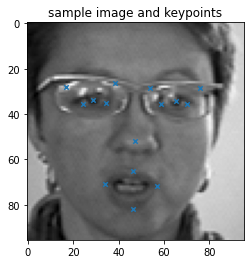

In [ ]:
sample_image_index = 10

train_images = convert_data_to_image(train)

train_keypoints = get_keypoints_features(train)

print(f'Shape of train images: {np.shape(train_images)}')
print(f'Shape of train_keypoints: {np.shape(train_keypoints)}')

fig, axis = plt.subplots()
plot_sample(train_images[sample_image_index], train_keypoints[sample_image_index], axis, "sample image and keypoints")

Shape of unclean train images: (7049, 96, 96, 1)
Shape of unclean train keypoints: (7049, 30)


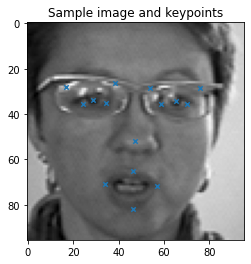

In [ ]:
sample_image_index = 10

unclean_train_images = convert_data_to_image(unclean_train_data)

unclean_train_keypoints = get_keypoints_features(unclean_train_data)

print(f"Shape of unclean train images: {np.shape(unclean_train_images)}")
print(f"Shape of unclean train keypoints: {np.shape(unclean_train_keypoints)}")

fig, axis = plt.subplots()
plot_sample(unclean_train_images[sample_image_index], unclean_train_keypoints[sample_image_index], axis, "Sample image and keypoints")


In [ ]:
test_images = convert_data_to_image(test)

test_keypoints = get_keypoints_features(test)

print(f"Shape of test_images: {np.shape(test_images)}")
print(f"Shape of test_keypoints: {np.shape(test_keypoints)}")

Shape of test_images: (1783, 96, 96, 1)
Shape of test_keypoints: (1783, 1)


In [ ]:
full_train_images = train_images

full_train_keypoints = train_keypoints

full_train_images = np.concatenate((full_train_images, unclean_train_images))
full_train_keypoints = np.concatenate((full_train_keypoints, unclean_train_keypoints))

In [ ]:
def left_right_flip(images, keypoint_features):
  flipped = []
  flipped_images = np.flip(images, axis=2)

  for i, sample_keypoints in enumerate(keypoint_features):
    flipped.append([96.-coord if i%2==0 else coord for index,coord in enumerate(sample_keypoints)])
  
  return flipped_images, flipped

Shape of flipped_train_images: (2140, 96, 96, 1)
Shape of flipped_train_keypoints: (2140, 30)
(11329, 96, 96, 1)
(11329, 30)


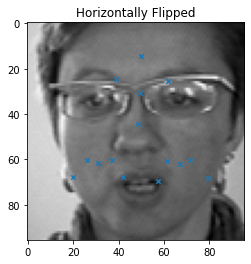

In [ ]:
horizontal_flip = True

flipped_train_images = np.array([])
flipped_train_keypoints = np.array([])

if horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(train_images, train_keypoints)
    print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images)))
    print("Shape of flipped_train_keypoints: {}".format(np.shape(flipped_train_keypoints)))
    
    full_train_images = np.concatenate((full_train_images, flipped_train_images))
    full_train_keypoints = np.concatenate((full_train_keypoints, flipped_train_keypoints))
    
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis, "Horizontally Flipped")
    
    print(full_train_images.shape)
    print(full_train_keypoints.shape)

In [ ]:
def rotate_aug(images, keypoints_features, rotation_angles):
    rotated_images = []
    rotated_keypoints_features = []
    for angle in rotation_angles:    
        for angle in [angle,-angle]:
            M = cv2.getRotationMatrix2D((img_height/2,img_width/2), angle, 1.0)
            angle_rad = -angle*math.pi/180
            
            
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (img_height,img_width), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)

            for keypoint in keypoints_features:
                rotated_keypoint = keypoint - img_height/2.    
                
                for idx in range(0,len(rotated_keypoint),2):
                    rotated_keypoint[idx] = rotated_keypoint[idx]*math.cos(angle_rad)-rotated_keypoint[idx+1]*math.sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*math.sin(angle_rad)+rotated_keypoint[idx+1]*math.cos(angle_rad)
                    
                rotated_keypoint += img_height/2
                rotated_keypoints_features.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,img_height,img_width,1)), rotated_keypoints_features


Shape of rotated train images: (0,)
Shape of rotated train keypoints: (0,)
(15609, 96, 96, 1)
(15609, 30)


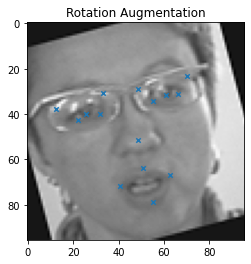

In [ ]:
rotation_augmentation = True

rot_angles = [ 15 ]

rotated_T_images = np.array([])
rotated_T_keypoints = np.array([])

if rotation_augmentation:
  rotated_train_images, rotated_train_keypoints_features = rotate_aug(train_images, train_keypoints, rot_angles)

  print(f'Shape of rotated train images: {np.shape(rotated_T_images)}')
  print(f'Shape of rotated train keypoints: {np.shape(rotated_T_keypoints)}')

  full_train_images = np.concatenate((full_train_images, rotated_train_images))
  full_train_keypoints = np.concatenate((full_train_keypoints, rotated_train_keypoints_features))

  fig, axis = plt.subplots()
  plot_sample(rotated_train_images[sample_image_index], rotated_train_keypoints_features[sample_image_index], axis, "Rotation Augmentation")
    
  print(full_train_images.shape)
  print(full_train_keypoints.shape)

In [ ]:
def alter_brightness(images, keypoints):
  altered_brightness_images = []

  inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)
  dec_bgitheness_images = np.clip(images*0.6, 0.0, 1.0)

  altered_brightness_images.extend(inc_brightness_images)
  altered_brightness_images.extend(dec_bgitheness_images)

  return altered_brightness_images, np.concatenate((keypoints, keypoints))


Shape of altered_brightness_train_images: (4280, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (4280, 30)
(19889, 96, 96, 1)
(19889, 30)


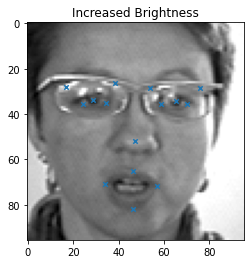

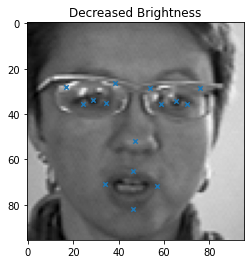

In [ ]:
brightness_augmentation = True

altered_brightness_train_images = np.array([])
altered_brightness_train_keypoints = np.array([])

if brightness_augmentation:
  altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(train_images, train_keypoints)
  print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")
  print(f"Shape of altered_brightness_train_keypoints: {np.shape(altered_brightness_train_keypoints)}")


  full_train_images = np.concatenate((full_train_images, altered_brightness_train_images))
  full_train_keypoints = np.concatenate((full_train_keypoints, altered_brightness_train_keypoints))

  fig, axis = plt.subplots()
  plot_sample(altered_brightness_train_images[sample_image_index], altered_brightness_train_keypoints[sample_image_index], axis, "Increased Brightness") 

  fig, axis = plt.subplots()
  image_plot =  altered_brightness_train_images[len(altered_brightness_train_images)//2+sample_image_index]
  keypoints_plot = altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+sample_image_index]
  plot_sample(image_plot, keypoints_plot, axis, "Decreased Brightness") 

  print(full_train_images.shape)
  print(full_train_keypoints.shape)

In [ ]:
def shift_images(images, keypoints, pixel_shifts):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            matrix = np.float32([[1,0,shift_x],[0,1,shift_y]])
            
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, matrix, (img_height,img_width), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<img_height):
                    shifted_images.append(shifted_image.reshape(img_height,img_width,1))
                    shifted_keypoints.append(shifted_keypoint)
                    
    shifted_keypoints = np.clip(shifted_keypoints,0.0,img_height)
    return shifted_images, shifted_keypoints

Shape of shifted_train_images: (6350, 96, 96, 1)
Shape of shifted_train_keypoints: (6350, 30)
(26239, 96, 96, 1)
(26239, 30)


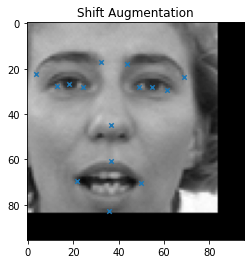

In [ ]:
shift_augmentation = True
pixel_shifts = [12] 

if shift_augmentation:
  shifted_train_images, shifted_train_keypoints = shift_images(train_images, train_keypoints, pixel_shifts)
  print(f"Shape of shifted_train_images: {np.shape(shifted_train_images)}")
  print(f"Shape of shifted_train_keypoints: {np.shape(shifted_train_keypoints)}")
  
  full_train_images = np.concatenate((full_train_images, shifted_train_images))
  full_train_keypoints = np.concatenate((full_train_keypoints, shifted_train_keypoints))

  fig, axis = plt.subplots()
  plot_sample(shifted_train_images[sample_image_index], shifted_train_keypoints[sample_image_index], axis, "Shift Augmentation")
  
  print(full_train_images.shape)
  print(full_train_keypoints.shape)

In [ ]:
def add_noise(images):
  noisy_images = []
  for image in images:
      noisy_image = cv2.add(image, 0.008*np.random.normal(img_height, img_width, 1))
      noisy_images.append(noisy_image.reshape(img_height, img_width, 1))
      
  return noisy_images

Shape of noisy_train_images: (2140, 96, 96, 1)
(28379, 96, 96, 1)
(28379, 30)


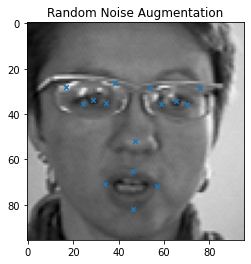

In [ ]:
random_noise_augmentation = True

if random_noise_augmentation:
  noisy_train_images = add_noise(train_images)
  
  print(f"Shape of noisy_train_images: {np.shape(noisy_train_images)}")
  
  full_train_images = np.concatenate((full_train_images, noisy_train_images))
  full_train_keypoints = np.concatenate((full_train_keypoints, train_keypoints))
  
  fig, axis = plt.subplots()
  plot_sample(noisy_train_images[sample_image_index], train_keypoints[sample_image_index], axis, "Random Noise Augmentation")
  
  print(full_train_images.shape)
  print(full_train_keypoints.shape)

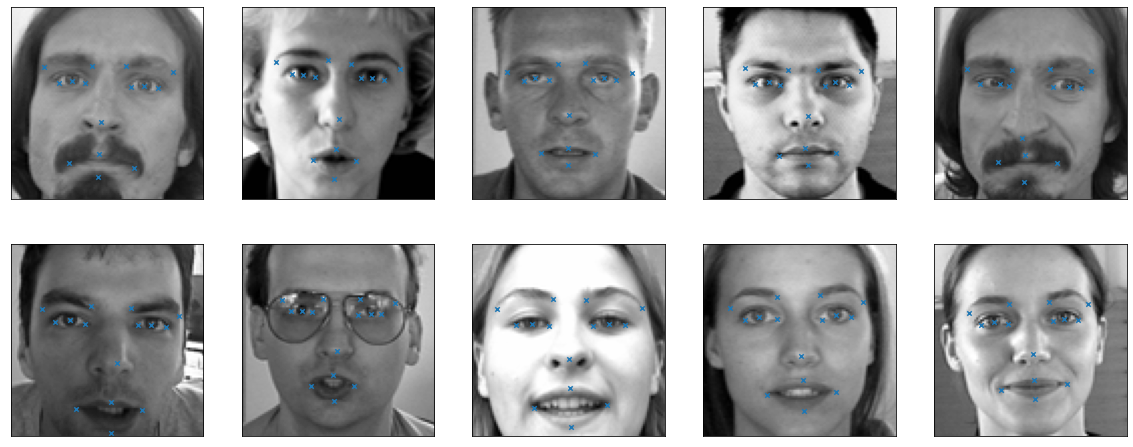

In [ ]:
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(train_images[i], train_keypoints[i], axis, "")
plt.show()

Horizontal Flip Augmentation: 


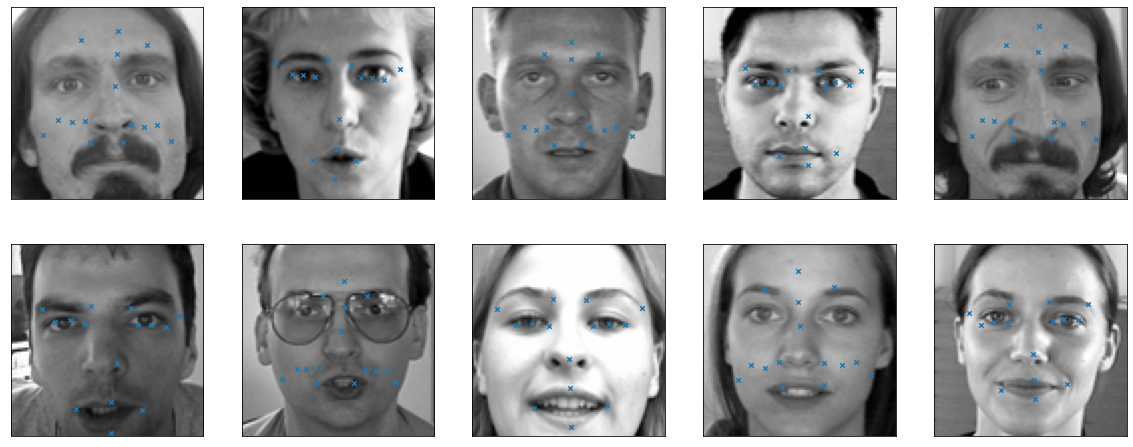

In [ ]:
if horizontal_flip:
    print("Horizontal Flip Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
        plot_sample(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
    plt.show()

Rotation Augmentation: 


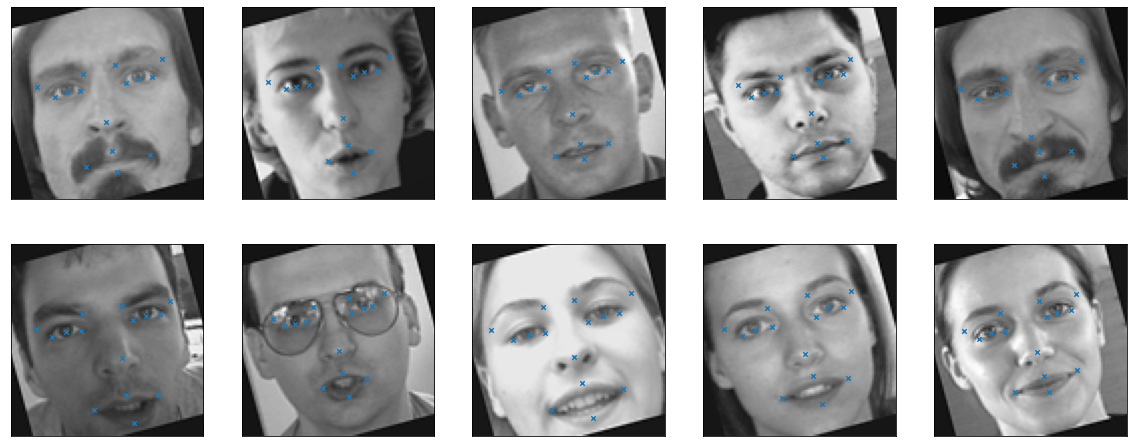

In [ ]:
if rotation_augmentation:
    print("Rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(rotated_train_images[i], rotated_train_keypoints_features[i], axis, "")
    plt.show()

Brightness Augmentation: 


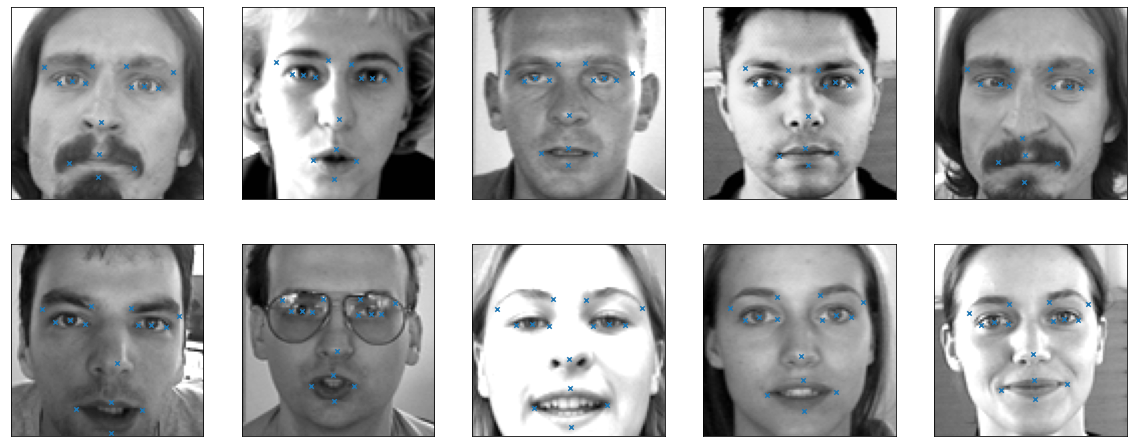

In [ ]:
if brightness_augmentation:
    print("Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

Shift Augmentation: 


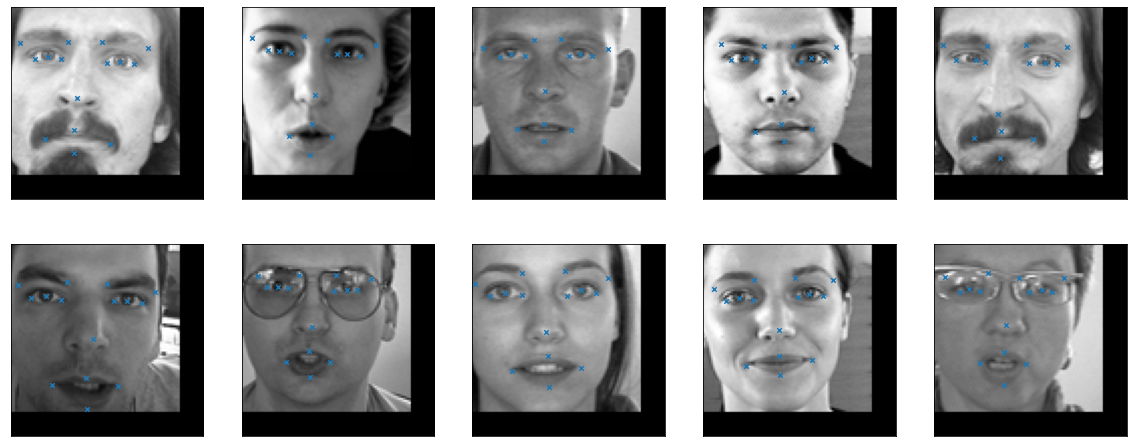

In [ ]:
if shift_augmentation:
    print("Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()

Random Noise Augmentation: 


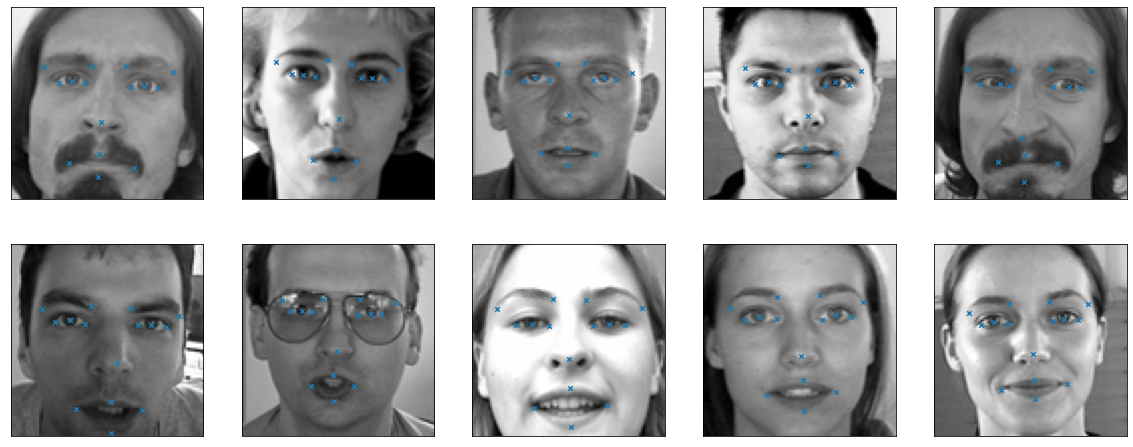

In [ ]:
if random_noise_augmentation:
    print("Random Noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(noisy_train_images[i], train_keypoints[i], axis, "")
    plt.show()

#DATA PRE-PROCESSING DONE

In [ ]:
full_train_images, full_train_keypoints = shuffle(full_train_images, full_train_keypoints, random_state=0)
print(full_train_images.shape)
print(full_train_keypoints.shape)

(28379, 96, 96, 1)
(28379, 30)


In [ ]:
"""CREATE MODEL"""
model = [
         
]

In [ ]:
#test_images
#test_keypoints

#full_train_images
#full_train_keypoints

#dataset size = 96 x 96 x 1

conv = Convolutional_2(8,3)
pool = MaxPool(2)
activation = Softmax_2(13)
loss = Losses()

def cnn_forward_propogation(image, keypoints):
  out = conv.foraward((image / 2) - 0.5)
  out = pool.forward(out)
  out = activation.forward(out)

